In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
import tomllib
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
config


In [14]:
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning("Datafile does not exist. First run src/preprocess.py, and check the timestamp!")

Lets load the data

In [15]:
df = pd.read_parquet(datafile)

Let's extract some more info from the timestamp:

In [16]:
df["date"] = df["timestamp"].dt.date
df["isoweek"] = df["timestamp"].dt.isocalendar().week
df["year-week"] = df["timestamp"].dt.strftime("%Y-%W")

Now, we can group by the isoweeks, for example. 
Let's reindex in order to fill the missing weeks.

In [17]:
df = df.drop(index=[0])

In [ ]:
p = df.groupby("year-week").count()
p.head()

In [ ]:
min_ts = df["timestamp"].min()
max_ts = df["timestamp"].max()
new_index = pd.date_range(start=min_ts, end=max_ts, freq='W', name="year-week").strftime('%Y-%W')
p = p.reindex(new_index, fill_value=0)
p.head()

Text(0.5, 1.0, 'Messages over time')

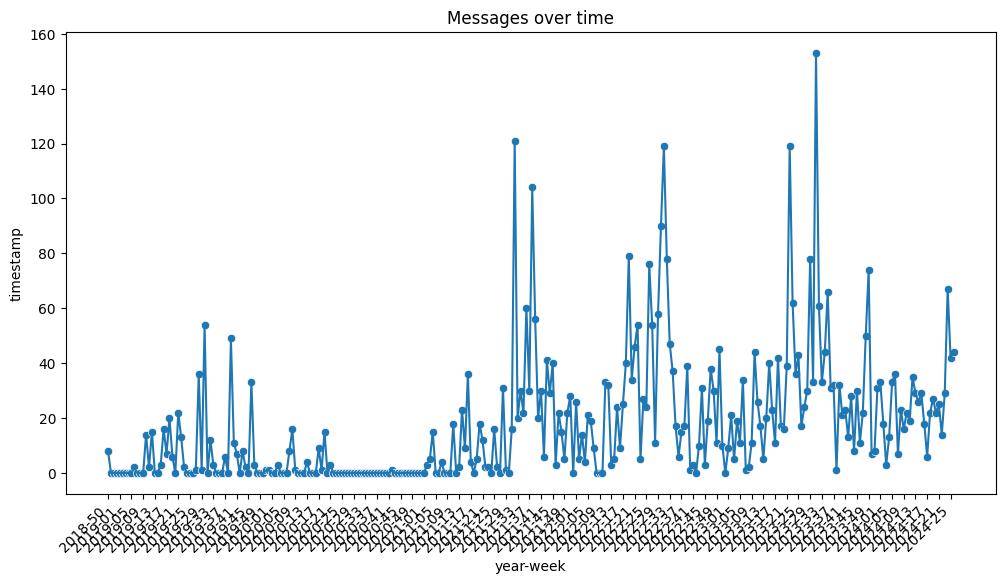

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(data=p, x=p.index, y="timestamp", ax=ax)
p["moving_avg"] = p["timestamp"].rolling(window=1).mean()
sns.lineplot(data=p, x=p.index, y="moving_avg", ax=ax)

interval = 4
xticks = p.index[::interval]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45, ha='right');
plt.title("Messages over time")


Try to play with the colors. Make sure adding colors conveys a message, and isnt randomly adding colors.
Probaly, a scatterplot and lineplot are not the best way to show the count of messages per author, per week, for your data, so you might need to modify that. It might not even be useful for your data to do this (eg because you have too many authors).

The main goal here is to find some way to visualise the count over time, per author, and to give you some starting point if that is relevant for your dataset.

In [25]:
df["day_of_week"] = df["timestamp"].dt.day_name()
df_agg = df.groupby(['date', 'day_of_week']).size().reset_index(name='message_count')


Sometimes, you want to group the timeseries in clusters, eg per day of the week (of per month, or per year, etc).
Facetgrid is a nice way to do this.

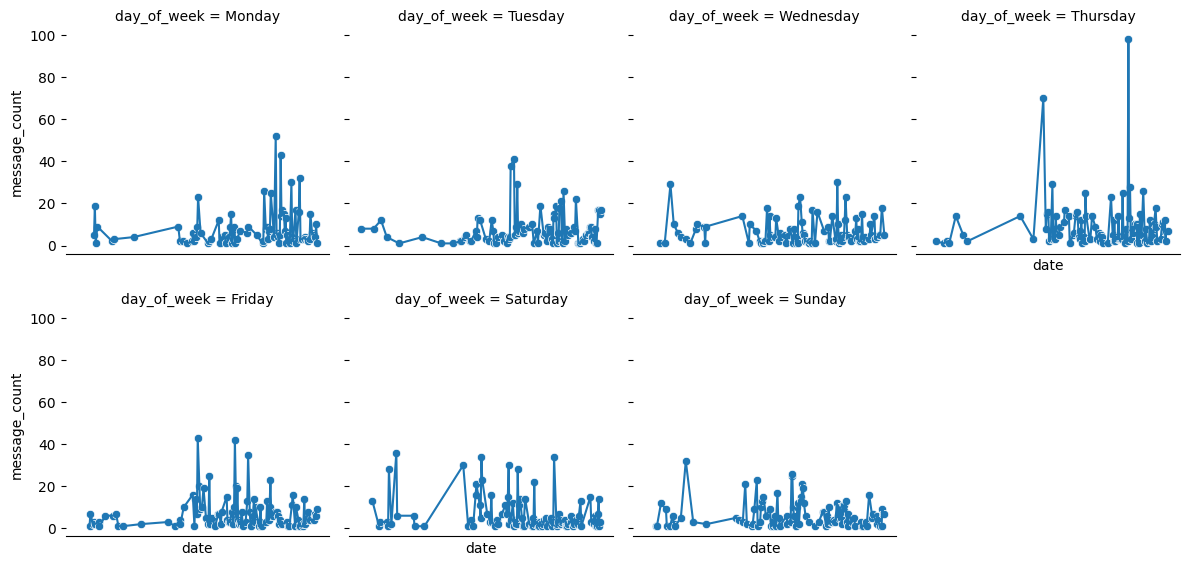

In [23]:
# Set the order of the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a FacetGrid to plot the line plots for each day of the week
g = sns.FacetGrid(df_agg, col='day_of_week', col_wrap=4, height=3, col_order=days_order)
g.map(sns.scatterplot, 'date', 'message_count')
g.map(sns.lineplot, 'date', 'message_count')
g.set(xticks=[])
g.despine(left=True, bottom=False)

Another nice plot is the area plot. Plotly has a nice version if this one.

# Code for two authors

I have experimented with two authors, and explored the question "who is the first (or last) of the day to send a message?".
I didnt tweak this for groupchats.

In [28]:
df_grouped = df.groupby('date').agg({
    'timestamp': ['min', 'max'],
    'author': ['first', 'last'],
    })
df_grouped.columns = df_grouped.columns.map("_".join)


In [30]:
df_grouped['timestamp_max_shifted'] = df_grouped['timestamp_max'].shift()

# Calculate the time difference
df_grouped['time_difference'] = df_grouped['timestamp_min'] - df_grouped['timestamp_max_shifted']


Text(0.5, 1.0, 'nimble-wombat +, effervescent-camel -')

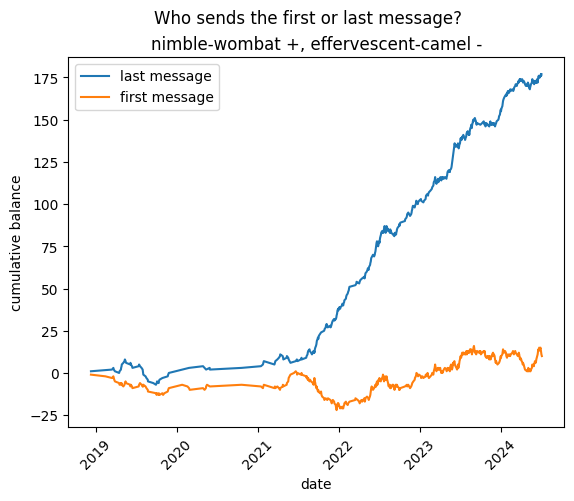

In [31]:
# this only works with two authors
mapping = {'nimble-wombat': 1, 'effervescent-camel' : -1}
df_grouped['last_message'] = df_grouped['author_last'].map(mapping)
df_grouped['first_message'] = df_grouped['author_first'].map(mapping)
df_grouped["last_balance"] = df_grouped['last_message'].cumsum()
df_grouped["first_balance"] = df_grouped['first_message'].cumsum()

sns.lineplot(data=df_grouped, x='date', y='last_balance', label="last message")
sns.lineplot(data=df_grouped, x='date', y='first_balance', label="first message")
plt.xticks(rotation=45);
plt.ylabel("cumulative balance")
plt.suptitle("Who sends the first or last message?")
plt.title("nimble-wombat +, effervescent-camel -")


In [32]:
def time_to_decimal(time_obj):
    return time_obj.hour + time_obj.minute / 60 + time_obj.second / 3600

df_grouped["decimal_first_time"] = df_grouped.timestamp_min.apply(time_to_decimal)
df_grouped["decimal_last_time"] = df_grouped.timestamp_max.apply(time_to_decimal)


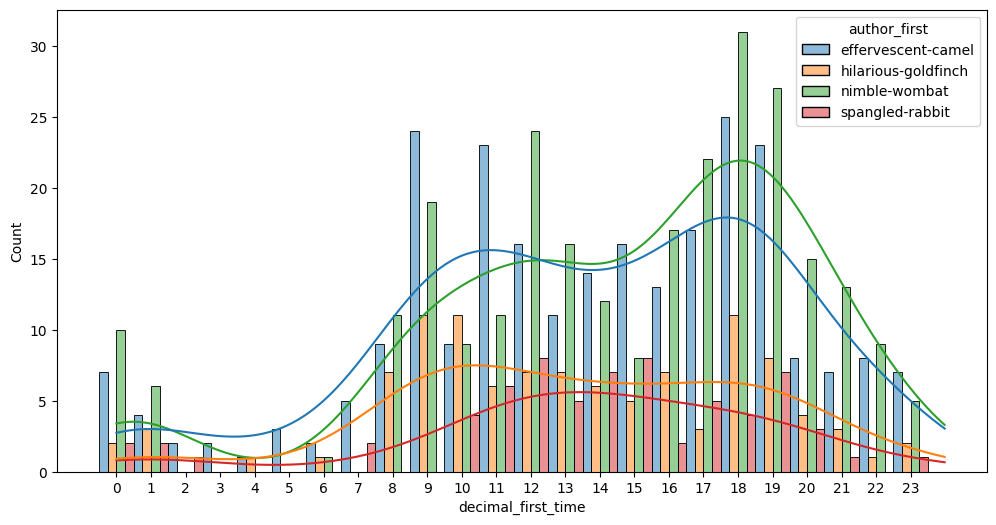

In [33]:

fig, ax = plt.subplots(figsize=(12, 6))
center = [t - 0.5 for t in range(0,25)]
sns.histplot(data=df_grouped,
    x='decimal_first_time',
    hue='author_first',
    common_norm=False,
    fill=True,
    bins=center,
    multiple="dodge",
    kde=True,
    ax=ax)
ax.set_xticks(range(0,24));

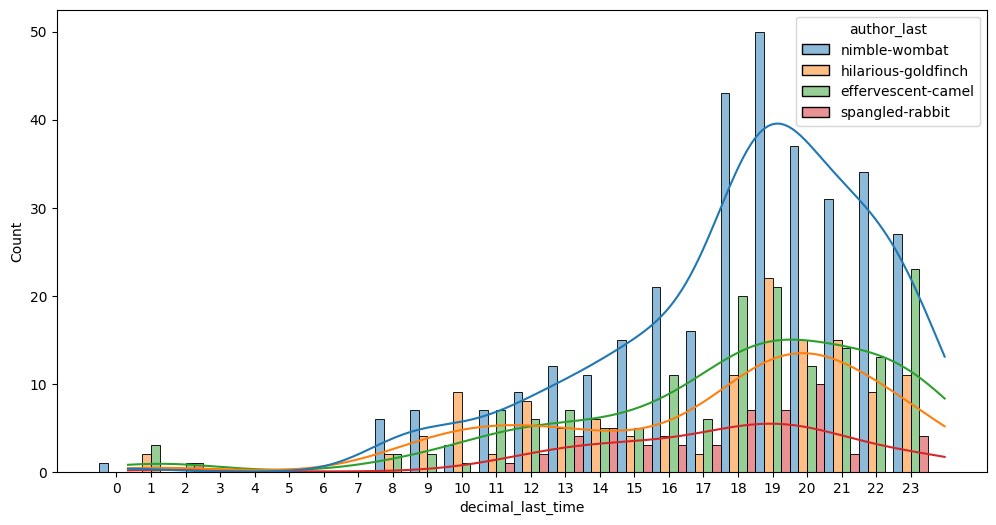

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
center = [t - 0.5 for t in range(0,25)]
sns.histplot(data=df_grouped,
    x='decimal_last_time',
    hue='author_last',
    common_norm=False,
    fill=True,
    bins=center,
    multiple="dodge",
    kde=True,
    ax=ax)
ax.set_xticks(range(0,24));

In [36]:
import numpy as np
def decimal_delta(td):
    if td == 0:
        return 0
    return td.total_seconds() / 3600

df["next_author"] = df.author.shift(-1)
df["next_timestamp"] = df.timestamp.shift(-1)
df["reaction_time"] = df.next_timestamp - df.timestamp
df["decimal_reaction_time"] = df.reaction_time.apply(decimal_delta)
df["reply"] = df.apply(lambda x: x.author != x.next_author, axis=1)

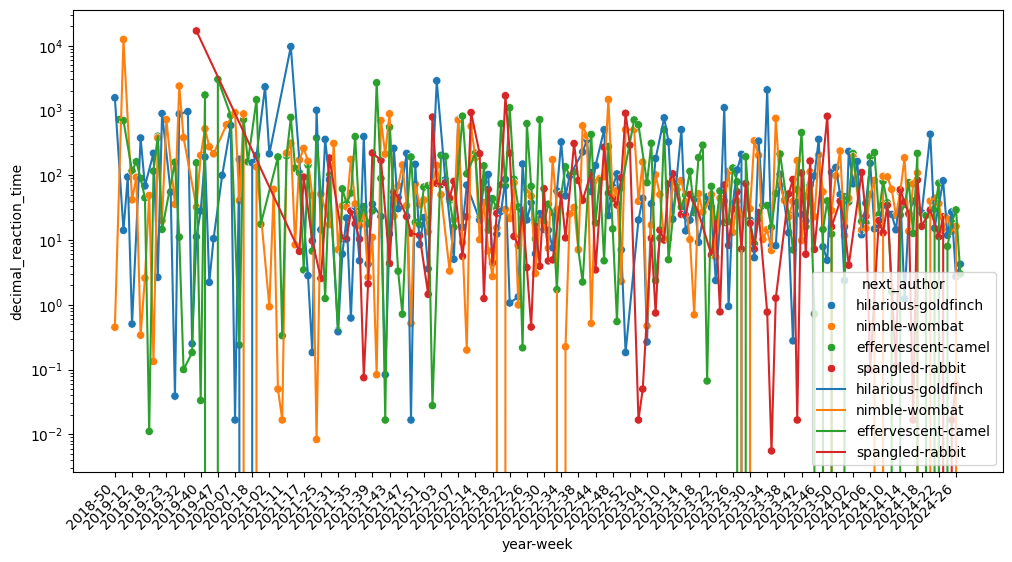

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
p = df[df.reply].groupby(['year-week', 'next_author']).agg({'decimal_reaction_time': 'mean'})
sns.scatterplot(data=p, x='year-week', y='decimal_reaction_time', hue='next_author', ax=ax)
sns.lineplot(data=p, x='year-week', y='decimal_reaction_time', hue='next_author', ax=ax)
plt.yscale('log')
interval = 4
xticks = p.reset_index()['year-week'].unique()[::interval]
# xticks = p.index[::interval]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45, ha='right');

(0.0, 24.0)

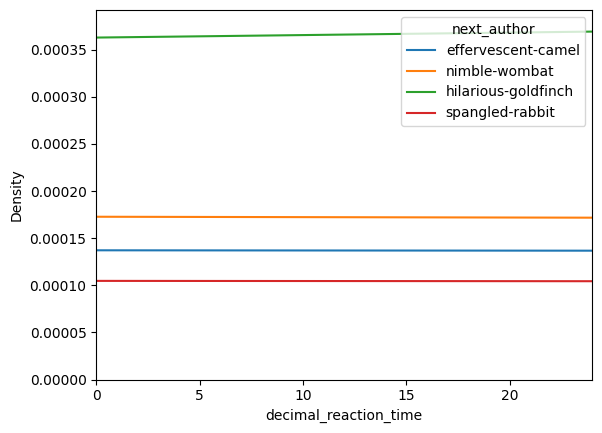

In [38]:
p = df[df.reply]

sns.kdeplot(
    data=p,
    x='decimal_reaction_time',
    hue='next_author'
)
plt.xlim((0,24))
# plt.yscale('log')

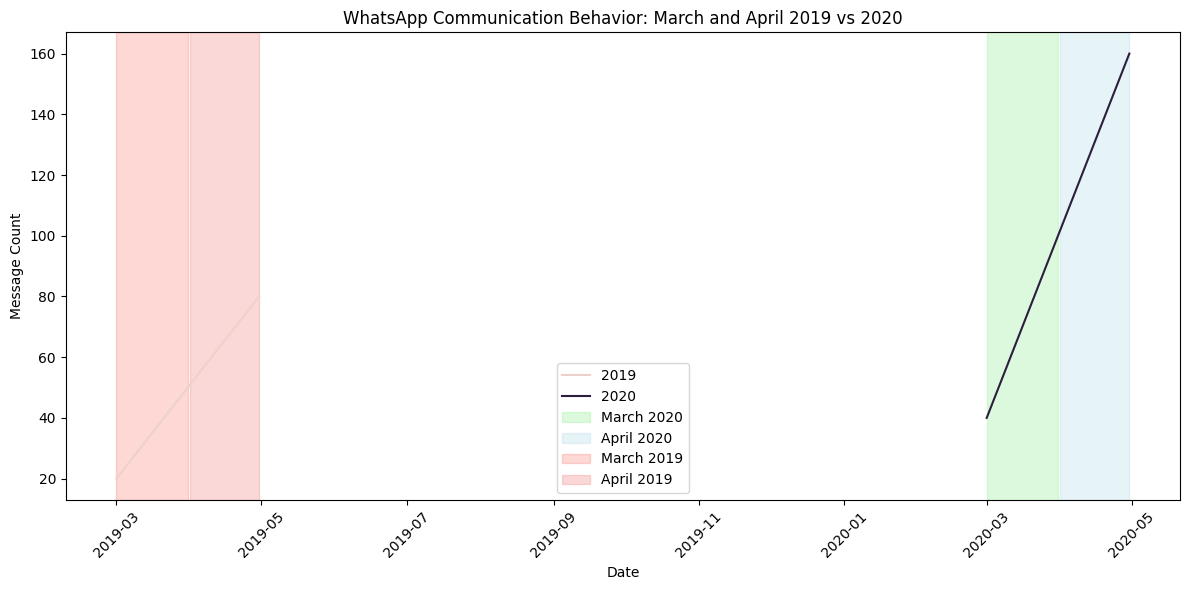

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame setup (replace this with your actual data)
# Create date ranges for March and April of 2019 and 2020
dates_2019 = pd.date_range(start='2019-03-01', end='2019-04-30', freq='D')
dates_2020 = pd.date_range(start='2020-03-01', end='2020-04-30', freq='D')

# Simulated message counts (replace with your actual data)
message_counts_2019 = [20 + i for i in range(len(dates_2019))]  # Simulated increase
message_counts_2020 = [40 + 2*i for i in range(len(dates_2020))]  # Simulated doubling

# Create DataFrames for each year
data_2019 = pd.DataFrame({'date': dates_2019, 'message_count': message_counts_2019})
data_2020 = pd.DataFrame({'date': dates_2020, 'message_count': message_counts_2020})

# Add a year column
data_2019['year'] = 2019
data_2020['year'] = 2020

# Concatenate the DataFrames
data = pd.concat([data_2019, data_2020])

# Set the date as the index
data.set_index('date', inplace=True)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=data, x=data.index, y='message_count', hue='year', ax=ax)

# Highlight the areas for March and April 2020
ax.axvspan('2020-03-01', '2020-03-31', color='lightgreen', alpha=0.3, label='March 2020')
ax.axvspan('2020-04-01', '2020-04-30', color='lightblue', alpha=0.3, label='April 2020')

# Highlight the areas for March and April 2019
ax.axvspan('2019-03-01', '2019-03-31', color='salmon', alpha=0.3, label='March 2019')
ax.axvspan('2019-04-01', '2019-04-30', color='lightcoral', alpha=0.3, label='April 2019')

# Customize the plot
plt.title("WhatsApp Communication Behavior: March and April 2019 vs 2020")
plt.xlabel("Date")
plt.ylabel("Message Count")
plt.xticks(rotation=45)
ax.legend()

plt.tight_layout()  # Adjust layout
plt.show()


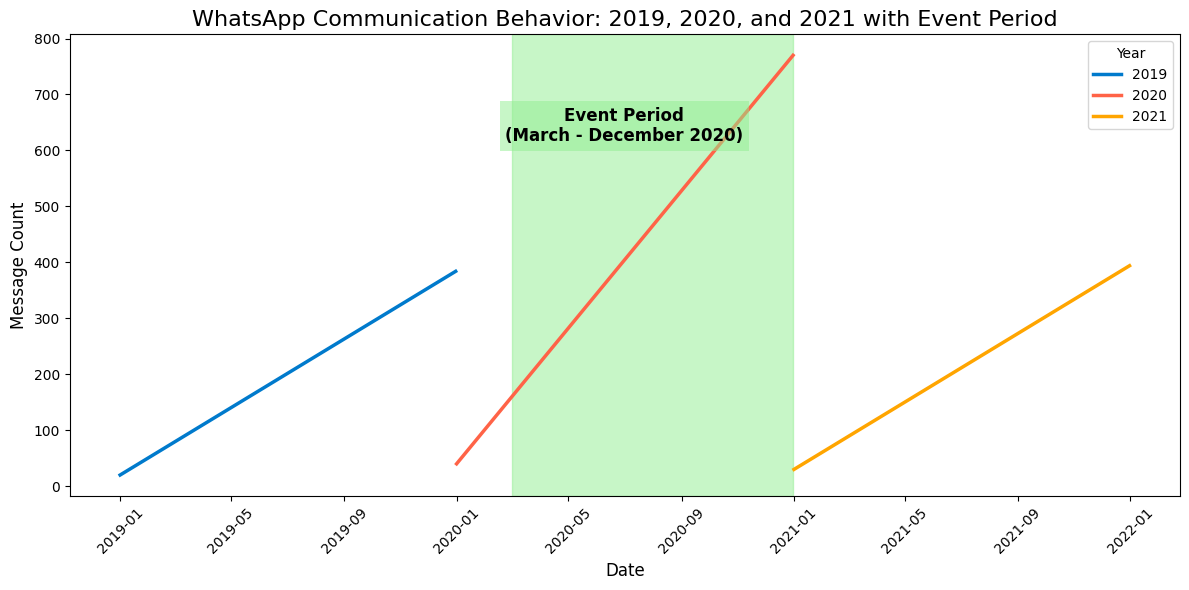

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame setup (replace this with your actual data)
dates_2019 = pd.date_range(start='2019-01-01', end='2019-12-31', freq='D')
dates_2020 = pd.date_range(start='2020-01-01', end='2020-12-31', freq='D')
dates_2021 = pd.date_range(start='2021-01-01', end='2021-12-31', freq='D')

# Simulated message counts (replace with your actual data)
message_counts_2019 = [20 + i for i in range(len(dates_2019))]  # Simulated count for 2019
message_counts_2020 = [40 + 2*i for i in range(len(dates_2020))]  # Simulated increase for 2020
message_counts_2021 = [30 + i for i in range(len(dates_2021))]  # Simulated count for 2021

# Create DataFrames for each year
data_2019 = pd.DataFrame({'date': dates_2019, 'message_count': message_counts_2019})
data_2020 = pd.DataFrame({'date': dates_2020, 'message_count': message_counts_2020})
data_2021 = pd.DataFrame({'date': dates_2021, 'message_count': message_counts_2021})

# Add a year column
data_2019['year'] = 2019
data_2020['year'] = 2020
data_2021['year'] = 2021

# Concatenate the DataFrames
data = pd.concat([data_2019, data_2020, data_2021])

# Set the date as the index
data.set_index('date', inplace=True)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set background color to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot with thicker lines and different styles
sns.lineplot(data=data, x=data.index, y='message_count', hue='year', ax=ax,
             linewidth=2.5, palette=['#007acc', '#ff6347', '#ffa500'])

# Highlight the event period from March to December 2020
ax.axvspan('2020-03-01', '2020-12-31', color='lightgreen', alpha=0.5)

# Add a label for the event period
ax.text(pd.Timestamp('2020-07-01'), max(data['message_count']) * 0.8, 'Event Period\n(March - December 2020)',
        horizontalalignment='center', fontsize=12, color='black', weight='bold',
        bbox=dict(facecolor='lightgreen', alpha=0.5, edgecolor='none'))

# Customize the plot
plt.title("WhatsApp Communication Behavior: 2019, 2020, and 2021 with Event Period", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Message Count", fontsize=12)
plt.xticks(rotation=45)
ax.legend(title='Year')

plt.tight_layout()  # Adjust layout
plt.show()

